In [1]:
%matplotlib inline

/Users/raymondyee/anaconda/envs/myenv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from settings import (WATTTIME_API_TOKEN, WATTTIME_USER, WATTTIME_PASSWORD)
import requests
import arrow, datetime

import numpy as np
import datetime as dt
import time

import matplotlib.pyplot as plt
import matplotlib.dates as md

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

# obtaining token

In [3]:
# https://api.watttime.org/api/v1/obtain-token-auth/

import urlparse

def obtain_token(username, password):
    
    base_url = 'https://api.watttime.org'
    endpoint = urlparse.urljoin(base_url, '/api/v1/obtain-token-auth/')
    
    payload = {'username': username, 
               'password': password
             }

    result = requests.post(endpoint, data=payload)
    return result.json()

( obtain_token(WATTTIME_USER, WATTTIME_PASSWORD).get('token')
  ==
  WATTTIME_API_TOKEN
)

True

# validating token

In [4]:
def validate_token (token):
    
    base_url = 'https://api.watttime.org'
    endpoint = urlparse.urljoin(base_url, '/api/v1/datapoints/')
    
    headers = {
        'Authorization': 'Token {}'.format(token)
    }
    
    result = requests.head(endpoint, headers=headers)
    return result.status_code == 200



# balance authority

```
https://api.watttime.org/api/v1/balancing_authorities/?loc={"type":"Point","coordinates":[-122.272778,37.871667]} 
```

In [5]:
import json

def balance_authority(lat, lon):
    
    base_url = 'https://api.watttime.org'
    endpoint = urlparse.urljoin(base_url, '/api/v1/balancing_authorities/')
    
    loc_info = json.dumps({
            'type': 'Point',
            'coordinates': [lon, lat]
        })
    
    
    params = {
        'loc': loc_info
    }
    
    result = requests.get(endpoint, params=params)
    return result.json()


In [6]:
balance_authority(lat=37.871667, lon=-122.272778)

[{u'abbrev': u'CAISO',
  u'ba_type': u'ISO',
  u'link': u'http://oasis.caiso.com/',
  u'name': u'California Independent System Operator',
  u'notes': u' ',
  u'states': [u'CA'],
  u'url': u'https://api.watttime.org/api/v1/balancing_authorities/CAISO/'}]

# generation mix

```
ba	
An abbreviation for a balancing authority. Options can be found at the 'balancing_authorities' endpoint. e.g., ba=ISONE	query	string
start_at	
Minimum timestamp (inclusive). e.g., start_at=2014-02-20 or start_at=2014-02-20T16:45:30-0800 or start_at=2014-02-20T16:45:30-08:00	query	string
end_at	
Maximum timestamp (inclusive). e.g., end_at=2014-02-20 or end_at=2014-02-20T16:45:30-0800 or end_at=2014-02-20T16:45:30-08:00	query	string
page_size	
Number of data points to return on each page. default is page_size=100, max is page_size=1000.	query	integer
freq	
Time series frequency. Options are '5m', '10m', '1hr', 'n/a'. e.g., freq=1hr	query	string
market
```

```
ba filters by place (see tutorial)
start_at and end_at filter by time (formatted like 2015-10-20T16:45:30-08:00)
market filters by data type (use RT5M to get past data from the real-time 5 minute market, or DAHR to get forecasted data from the day-ahead hourly market)
page_size sets the number of data points that are returned in a single query

```

In [7]:
arrow.get(datetime.datetime.utcnow()).isoformat()

'2016-10-26T04:00:21.240429+00:00'

In [8]:
def generation_mix(token, ba, start_at, end_at, page_size=100, market='RT5M', **kwargs):
    """
    * ba filters by place (see tutorial)
    * start_at and end_at filter by time (formatted like 2015-10-20T16:45:30-08:00)
    * market filters by data type (use RT5M to get past data from the real-time 5 minute market, 
        or DAHR to get forecasted data from the day-ahead hourly market)
    * page_size sets the number of data points that are returned in a single query
    """
    base_url = 'https://api.watttime.org'
    url = urlparse.urljoin(base_url, '/api/v1/datapoints/')
    
    headers = {
        'Authorization': 'Token {}'.format(token)
    }
    
    params = {
        'ba': ba,
        'start_at': arrow.get(start_at).isoformat(),
        'end_at': arrow.get(end_at).isoformat(),
        'page_size': page_size,
        'market': market
    }
    
    more_pages = True
    
    while more_pages:
    
        r = requests.get(url, params=params)
        results = r.json()['results']
        
        for result in results:
            yield result
        
        url = r.json()['next']
        more_pages = url is not None
    
    

In [9]:
arrow.utcnow()

<Arrow [2016-10-26T04:00:24.616006+00:00]>

In [10]:
# some number of minutes before to now

import datetime, pytz, arrow

now = arrow.now()
end_at = now
start_at = now.replace(minutes=-6000)

results = list(generation_mix(token = WATTTIME_API_TOKEN, ba='CAISO', start_at=start_at, end_at=end_at))
results[:1]

[{u'ba': u'CAISO',
  u'carbon': 1427.46177370031,
  u'created_at': u'2016-10-26T03:52:01.307615Z',
  u'freq': u'10m',
  u'genmix': [{u'fuel': u'other', u'gen_MW': 35008.5},
   {u'fuel': u'wind', u'gen_MW': 250.0},
   {u'fuel': u'renewable', u'gen_MW': 1529.0}],
  u'market': u'RT5M',
  u'timestamp': u'2016-10-26T03:50:00Z',
  u'url': u'https://api.watttime.org/api/v1/datapoints/9254999/'}]

In [11]:
# how to use django cache

from django.core.cache.backends.locmem import LocMemCache
cache = LocMemCache('rycache', {})

In [12]:
results = sorted(results, key = lambda s: s['timestamp'], reverse=True)
df = DataFrame(
    [(arrow.get(result['timestamp']).datetime, result['carbon'])  for result in results],
    columns = ['ts', 'carbon']
)
len(df)

585

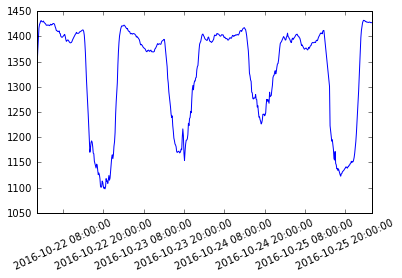

In [13]:
# http://stackoverflow.com/questions/4090383/plotting-unix-timestamps-in-matplotlib

plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)


plt.plot(df['ts'], df['carbon'])

# Using the Client

In [14]:
from watttime_client.client import WattTimeAPI
mytoken = WATTTIME_API_TOKEN
client = WattTimeAPI(token=mytoken)

In [15]:
from datetime import datetime
import pytz

timestamp = pytz.utc.localize(datetime(2016, 6, 1, 12, 30))
value = client.get_impact_at(timestamp, 'CAISO')

print(value)

KeyError: 'results'